# Paddock time series clustering STEP 2

Starting with an array of paddock x variable x time (pvt) and a geo dataframe of polygons

## Setup

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib

%matplotlib inline

import skimage
from dea_tools.plotting import display_map, rgb, xr_animation
import cv2 

from matplotlib.gridspec import GridSpec



In [3]:
# Function to check missing data in a pandas df found here: https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python

# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# unique identifier for the run 
stub = 'fm_ndwi_4'
#stub = 'ADAMO'
#stub = 'GRANT'

# location of the cached data sets
data_path = '/home/jovyan/Projects/PaddockTS/Data/Paddocks/'

In [6]:
# Read in the polygons
pol = gpd.read_file(data_path+stub+'_filt.gpkg')

# have to set a paddock id. Preferably do this in earlier step in future... 
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')


# Read in the array of paddocks by variables (e.g. bands) by time -- the pvt array
pvt = np.load(data_path+stub+'_pvt.npy')


# Read in the time stack of multiband sentinel data including index bands. 
ds = xr.open_dataset(data_path+stub+'_ds.nc')
# caution.. ds object appears a bit differently to in the previous notebook, not sure if it will cause problems.. .

# # read time axis (potentially not needed if loading ds working properly)
# time = pd.read_csv(data_path+stub+'_ds-time.csv',
#                   header = None)[1]


In [7]:
ds_weekly = ds.resample(time="1W").interpolate("linear")
#da = ds.to_dataarray()

ds_weekly


<xarray.Dataset>
Dimensions:      (time: 259, y: 529, x: 483)
Coordinates:
  * y            (y) float64 -4.129e+06 -4.129e+06 ... -4.14e+06 -4.14e+06
  * x            (x) float64 1.432e+07 1.432e+07 ... 1.433e+07 1.433e+07
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2019-01-13 2019-01-20 ... 2023-12-24
Data variables:
    nbart_red    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [8]:
ds_weekly.nbart_red

<xarray.DataArray 'nbart_red' (time: 259, y: 529, x: 483)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[1093.98423226, 1099.49721035, 1052.66006311, ...,
         1656.96539176, 1504.47836985, 1078.32012622],
        [1110.75369939, 1117.07786854, 1131.197461  , ...,
         1194.42087818, 1388.17765033, 1513.05652149],
        [1119.10382472, 1115.3516617 , 1083.15573708, ...,
         1443.29570641, 1499.58834007, 1602.88501667],
...
        [ 815.92849676, 1480.77094222, 1396.99438984, ...,
         1356.35979861, 1300.49386718, 1190.41342603],
        [1375.97651403, 1376.61338768, 1413.81002158, ...,
         1331.8983553 , 1290.88380724, 1119.56204267],
        [1357.23238552, 1462.25919924, 1415.44356749, ...,
         1358.78549029, 1233.8033661 , 1074.04136178]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]])
Coordinates:
  * y            (y) float64 -4.129e+06 -4.129e+06 ... -4.14e+06 -4.14e+06
  * x            (x) float64 1.432e+07 1.432e+07 ... 1.433e+07 1.433e+07
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2019-01-13 2019-01-20 ... 2023-12-24
Attributes:
    units:         1
    nodata:        -999
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Check the data before starting time series analyses:

In [9]:
# check out locations of the paddocks:
pol.explore(column='paddock')

number of missing pixels across all ndvi ts : 59


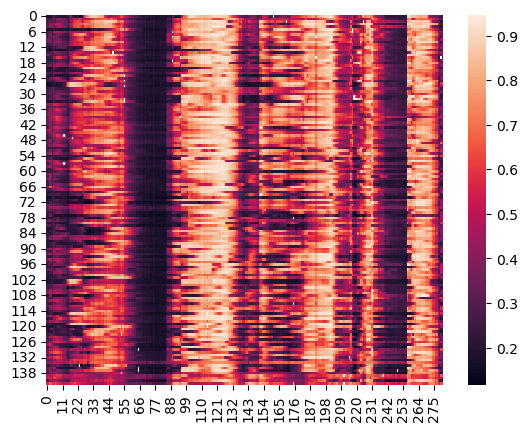

In [10]:
# get array into paddock-time-variable (ptv)

ptv = np.rollaxis(pvt, axis = 1, start = 3)

# check ndvi time series for all paddocks
pt_ndvi = ptv[:,:,4]
sns.heatmap(pt_ndvi)

print('number of missing pixels across all ndvi ts :', np.count_nonzero(np.isnan(pt_ndvi)))


In [11]:
ptv.shape

(143, 282, 6)

## Time series analyses

In [12]:
# following tslearn and the sklearn kits, get the data into a pandas dataframe with column for datetime and a column for each paddock:

pads = list(pol.paddock)
df = pd.DataFrame(pt_ndvi.T,
                 columns = pads)

# check missing data:
#print(missing_values_table(df))

df = df.interpolate(method = 'linear', axis = 'columns')
df

df.insert(loc=0, column='datetime', value = ds.time.values)
df.shape

(282, 144)

In [13]:
df.head()

datetime         1         2         3         4  \
0 2019-01-13 00:16:12.387000064  0.202415  0.260204  0.271914  0.287174   
1 2019-01-15 00:06:13.116999936  0.189124  0.246307  0.280005  0.288817   
2 2019-01-23 00:16:13.228999936  0.192555  0.258545  0.319271  0.396574   
3 2019-01-25 00:06:13.900999936  0.206612  0.272793  0.339915  0.407570   
4 2019-01-30 00:06:17.484999936  0.233653  0.282723  0.314384  0.380780   

          5         6         7         8         9  ...       134       135  \
0  0.296739  0.194884  0.257165  0.264192  0.277941  ...  0.273657  0.366990   
1  0.314800  0.181148  0.277744  0.279795  0.300936  ...  0.273929  0.380263   
2  0.407597  0.169694  0.321609  0.354562  0.349702  ...  0.330869  0.403210   
3  0.415791  0.179326  0.320469  0.349895  0.317540  ...  0.346929  0.409642   
4  0.373080  0.177658  0.284235  0.302830  0.257239  ...  0.362410  0.419593   

        136       137       138       139       140       141       142  \
0  0.255896  0.327869  0.279659  0.283715  0.461485  0.527064  0.288177   
1  0.246170  0.336901  0.307567  0.298765  0.486860  0.555085  0.295765   
2  0.269241  0.389549  0.395017  0.398589  0.510686  0.565172  0.425233   
3  0.290521  0.376561  0.372860  0.387522  0.515667  0.523881  0.429378   
4  0.291712  0.335705  0.327092  0.339549  0.510460  0.489836  0.394781   

        143  
0  0.565894  
1  0.599709  
2  0.658676  
3  0.649333  
4  0.613558  

[5 rows x 144 columns]

In [14]:
### Resample the pandas df to weekly time series and select a single year. 

def get_weekly(df, interval, start, stop, interpolate = True):
    
    '''resample the time series to an equal window (take median) for nice annual periodicity, 
    truncate to a specific time interval for potentially easier clustering,
    interpolate over missing time windows
    
    Input: a pandas df with first column datetime and columns for each paddock
    Returns: a new pandas df '''
    
    import datetime 
    datetime.datetime.strptime

    # interval = '7D'
    # start = '2020-01-01'
    # stop = '2021-01-01'
    # interpolate = True

    df_resamp = df[(df['datetime'] > start) & (df['datetime'] < stop)]

    df_resamp = df_resamp.set_index('datetime').resample(interval).median()
    
    before = df_resamp.mean(axis=1).to_frame()

    if interpolate == True:
        df_resamp = df_resamp.interpolate(method = 'linear', axis = 'rows') # Careful. sometimes we're going 3+ weeks without data....
    
    df_resamp['datetime'] = df_resamp.index
    
    after = df_resamp.mean(axis=1).to_frame()    
    
    ba = pd.DataFrame(columns = ['before', 'after'])
    ba['before'] = before
    ba['after'] = after
    ba['datetime'] = ba.index
    
    ax1 = ba.plot(kind='scatter', x='datetime', y='after', color='r')    
    ax2 = ba.plot(kind='scatter', x='datetime', y='before', color='b', ax=ax1)    

    print(ax1 == ax2)  # True
    
    return(df_resamp)

### In future, generate time series plot of the mean NDVI before and after interpolation to show extent and effect of missing data. 


/tmp/ipykernel_139/430739002.py:31: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after = df_resamp.mean(axis=1).to_frame()
/tmp/ipykernel_139/430739002.py:31: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after = df_resamp.mean(axis=1).to_frame()


True
True


(103, 144)

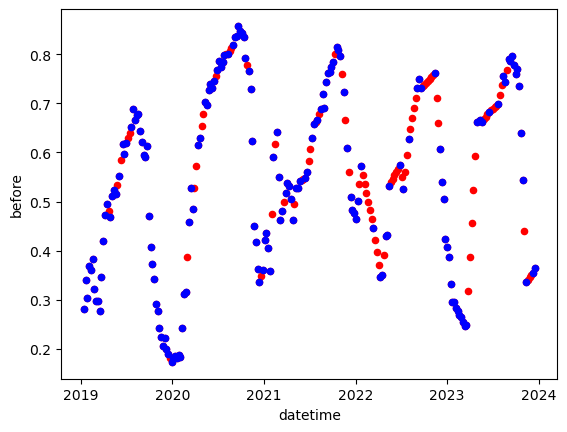

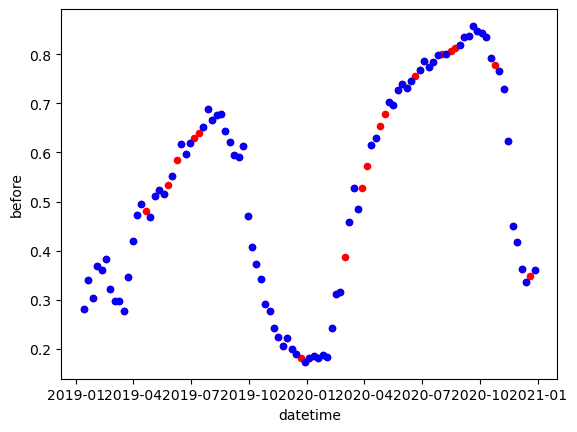

In [16]:
#df_ = get_weekly(df, '7D', '2019-01-01', '2024-01-01', interpolate = True)
df_ = get_weekly(df, '7D', '2019-01-01', '2021-01-01', interpolate = True)

df_.shape

In [17]:
# interpolate didn't work properly.. there are still nans. 

df_ = df_.dropna(axis = 0)
df_.shape

(103, 144)

In [18]:
df.mean(axis=1)

/tmp/ipykernel_139/3676274908.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.mean(axis=1)


0      0.275010
1      0.285777
2      0.339206
3      0.339472
4      0.303476
         ...   
277    0.547416
278    0.358368
279    0.313364
280    0.355089
281    0.364060
Length: 282, dtype: float32

In [15]:
# check out a single paddock ts


In [20]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler

X = df_.T.drop('datetime')

# Normalization
X_train = TimeSeriesScalerMeanVariance().fit_transform(X) # transform or not?


In [21]:
missing_values_table(X)

# X can't have ANY missing values..

Your selected dataframe has 103 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [22]:
X_train.shape

(143, 103, 1)

### Don't run boxes below

In [ ]:
# From here:
# https://levelup.gitconnected.com/unveiling-patterns-in-time-a-guide-to-time-series-clustering-with-tslearn-50a2ff305afe

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

# Set a seed for reproducibility
seed = 0
np.random.seed(seed)

# Set the number of clusters
n_clusters = 4

# from tslearn.datasets import CachedDatasets
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace") 

# # Resampling: Make time series shorter
# X_train = TimeSeriesResampler(sz=50).fit_transform(X)

# Normalization
X_train = TimeSeriesScalerMeanVariance().fit_transform(X) # transform or not?
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X) # transform or not?

# TimeSeriesKMeans with DTW
model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True,metric="dtw")

# much faster with euclidian than dtw clustering.. 

In [ ]:
# Visualizing the clustering results
plt.figure(figsize=(9, 8))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()


In [ ]:
# Set a seed for reproducibility
seed = 0
np.random.seed(seed)
# Set the number of clusters
n_clusters = 10
# from tslearn.datasets import CachedDatasets
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")


# # Resampling: Make time series shorter
# X_train = TimeSeriesResampler(sz=50).fit_transform(X_train)

# # Normalization
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

from tslearn.clustering import KShape, KernelKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

# clustering algorithms
clustering_algorithms = {
    "KMeans": TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10, n_init=2, n_jobs=-1),
    'dtw': TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, n_init=2 , n_jobs=-1),
    'softdtw':TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=5, n_init=2, n_jobs=-1),
    'kshape':KShape(n_clusters=n_clusters, max_iter=10, n_init=2),
    'kernelkmeans':KernelKMeans(n_clusters=n_clusters, kernel="gak", max_iter=5, n_init=2, n_jobs=-1),
}

best_algorithm = None
best_score = float("-inf")

# Iterate through each clustering algorithm
for algorithm_name, algorithm in clustering_algorithms.items():
    # Apply the current clustering algorithm
    y_pred = algorithm.fit_predict(X_train)
    # Evaluate the clustering performance using silhouette score
    score = silhouette_score(X_train, y_pred)

    print(f"{algorithm_name} - Silhouette Score: {score}")

    # Check if the current algorithm has a higher silhouette score
    if score > best_score:
        best_score = score
        best_algorithm = algorithm_name

# Print the best clustering algorithm
print(f"The best clustering algorithm is: {best_algorithm} with Silhouette Score: {best_score}")

 k: 2 	 Inertia: 3.8478925677474694 	 Silhouette Score: 0.20550052018300752
 k: 4 	 Inertia: 3.087718006638545 	 Silhouette Score: 0.10831296415997546
 k: 6 	 Inertia: 2.670344553826995 	 Silhouette Score: 0.12220189673942668
 k: 8 	 Inertia: 2.403284188824023 	 Silhouette Score: 0.09849339915233221
 k: 10 	 Inertia: 2.2636177602717424 	 Silhouette Score: 0.08753830131637598
 k: 12 	 Inertia: 2.0897729858924636 	 Silhouette Score: 0.08908879827574996
 k: 14 	 Inertia: 1.9832264044879955 	 Silhouette Score: 0.08532331583548532


<Axes: xlabel='clusters'>

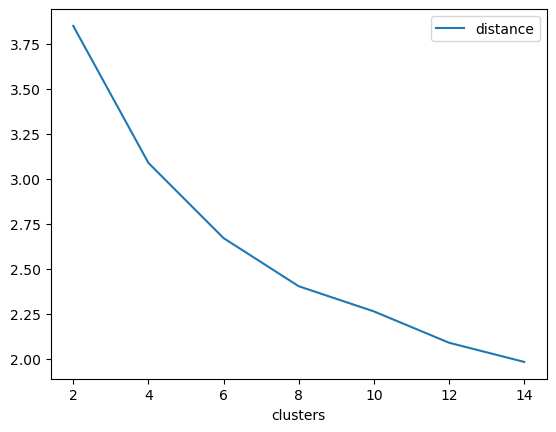

In [27]:
## k--means clustering
# determine number of clusters using the elbow method:

from tslearn.clustering import KShape, KernelKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

elbow_data = []
for n_clusters in range (2,15,2):
#     train_ts = train['u_in'].values.reshape(-1, 80)
#     y = train['pressure'].values
#     test_ts = test['u_in'].values.reshape(-1, 80)

#     X_train = train_ts[:1000] # using only first 1.000 as a sample

    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=42,n_jobs=-1, metric = 'dtw')
    y_pred = km.fit_predict(X_train)
    
    elbow_data.append((n_clusters, km.inertia_))
    
    score = silhouette_score(X_train, y_pred)
    
    print(f' k: {n_clusters} \t Inertia: {km.inertia_} \t Silhouette Score: {score}')

pd.DataFrame(elbow_data,columns=['clusters', 'distance']).plot(x='clusters',y='distance')


In [26]:
print(len(y_pred))
print(X_train.shape)

119
(119, 255, 1)


### Start again here

In [23]:
### PLOT clusters for specified k-value

from tslearn.clustering import KShape, KernelKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

N_CLUSTERS= 5

# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, verbose=False, random_state=42,n_jobs=-1, metric = 'dtw')
y_pred = km.fit_predict(X_train)


In [24]:
y_pred

array([0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 2, 3, 1, 1, 1, 1, 0, 1, 1, 2, 2, 3,
       1, 1, 2, 2, 2, 2, 2, 1, 4, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 4, 2,
       2, 1, 3, 1, 1, 2, 1, 4, 4, 0, 4, 4, 0, 2, 0, 0, 1, 2, 1, 4, 3, 4,
       1, 2, 1, 4, 1, 0, 1, 1, 4, 0, 2, 0, 2, 0, 4, 3, 4, 3, 2, 3, 4, 1,
       4, 3, 4, 2, 2, 1, 4, 3, 4, 4, 3])

In [25]:
X_train.shape

(143, 103, 1)

<Figure size 640x480 with 0 Axes>

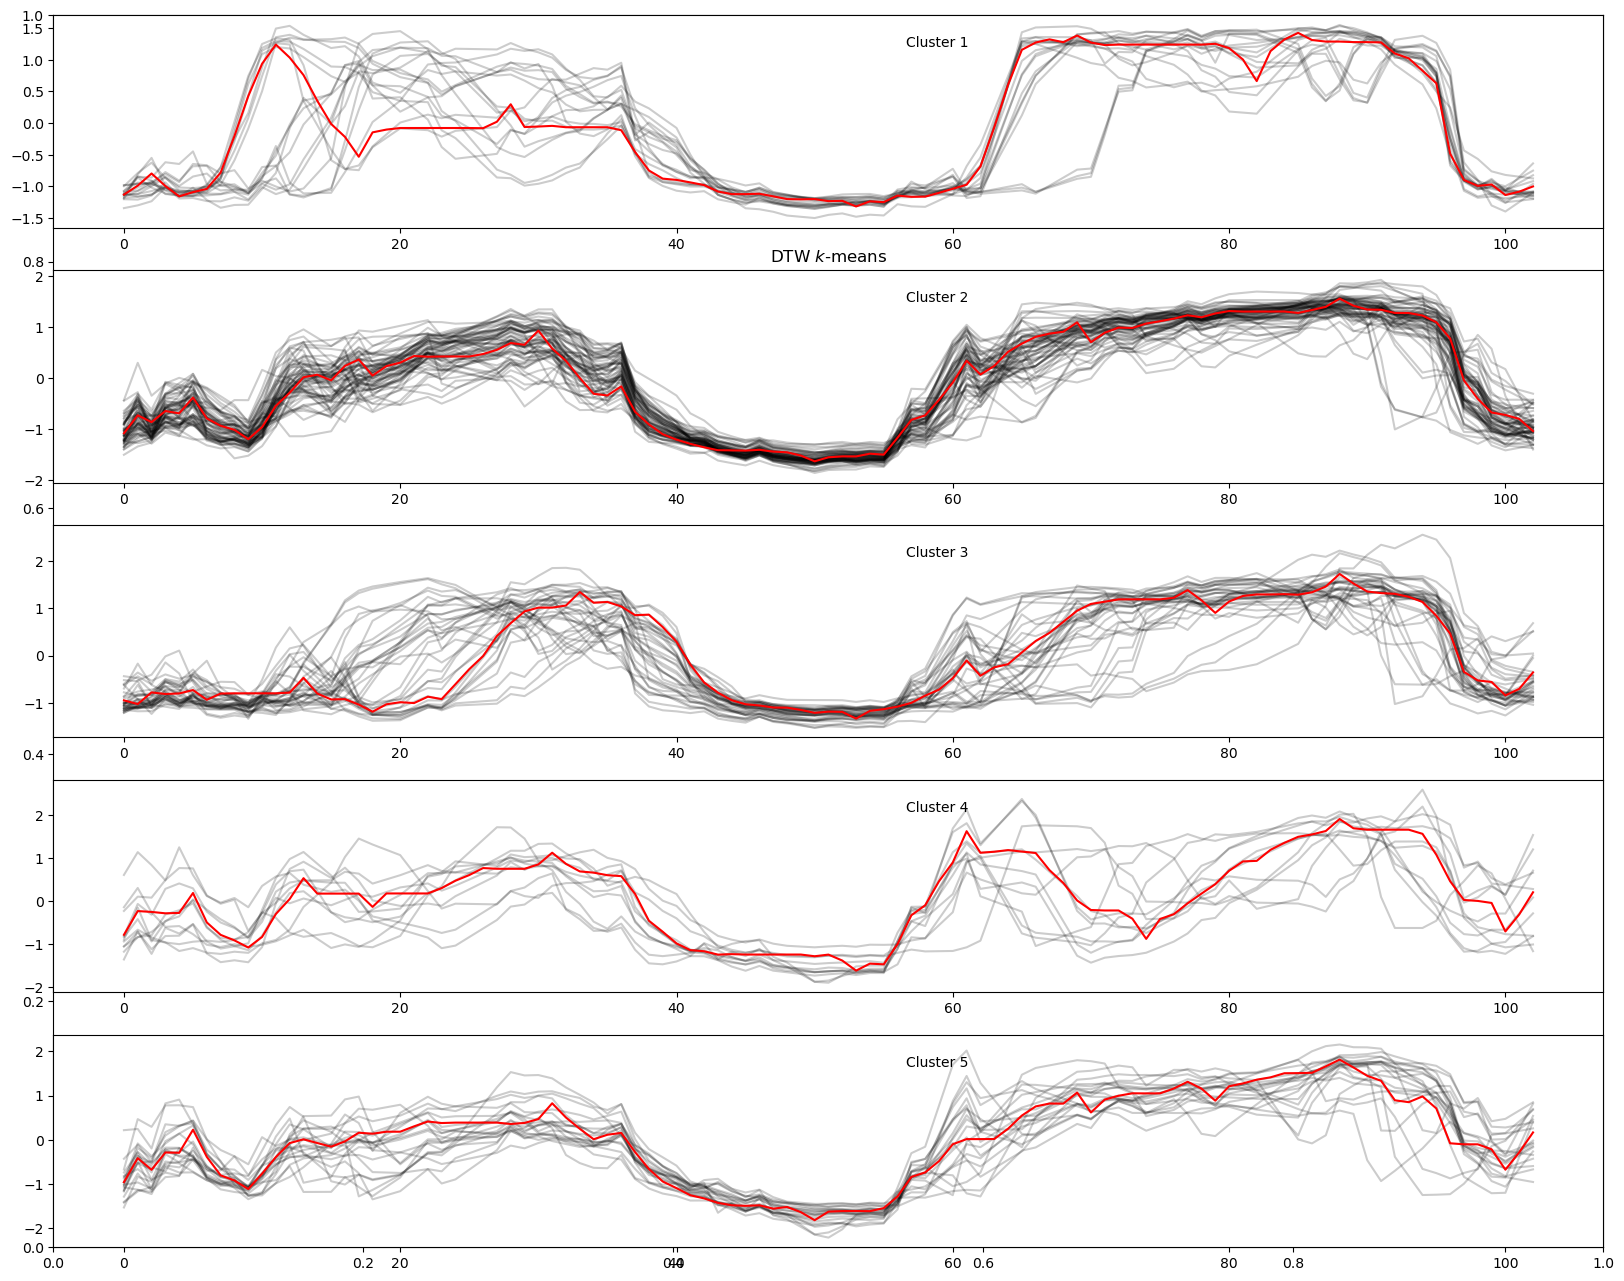

In [26]:
plt.figure()
plt.subplots(figsize = (20, 16))
for yi in range(N_CLUSTERS):
    plt.subplot(N_CLUSTERS,1 , yi + 1) # Sets the plot panel layout (make sure the n_rows and n_cols multiply to get approx N_CLUSTERS)
    for xx in X_train[y_pred == yi]: # takes the NDVI time series (from X_train) for rows corresponding to a specified cluster
        plt.plot(xx.ravel(), "k-", alpha=.2) # plots the trace for each paddock with some transparancy (alpha<1)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-") # plots trace of the "average" paddock in the cluster
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

Text(0.5, 1.0, 'DTW $k$-means')

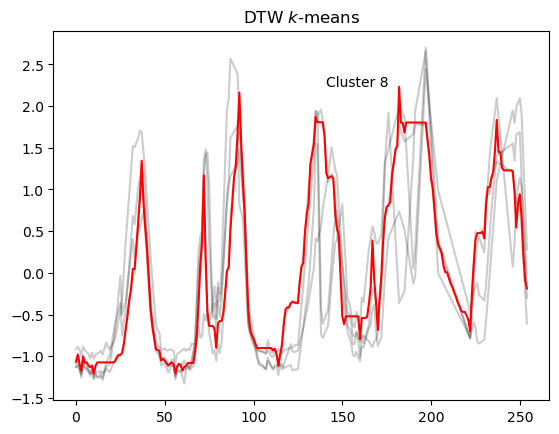

In [27]:
# check out spatial clustering patterns:
pol['y_pred'] = y_pred
pol['y_pred'] = pol['y_pred'].astype('category')
pol.explore(column='y_pred')

In [ ]:
## Save the polygons with cluster association. 

# to do



/env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


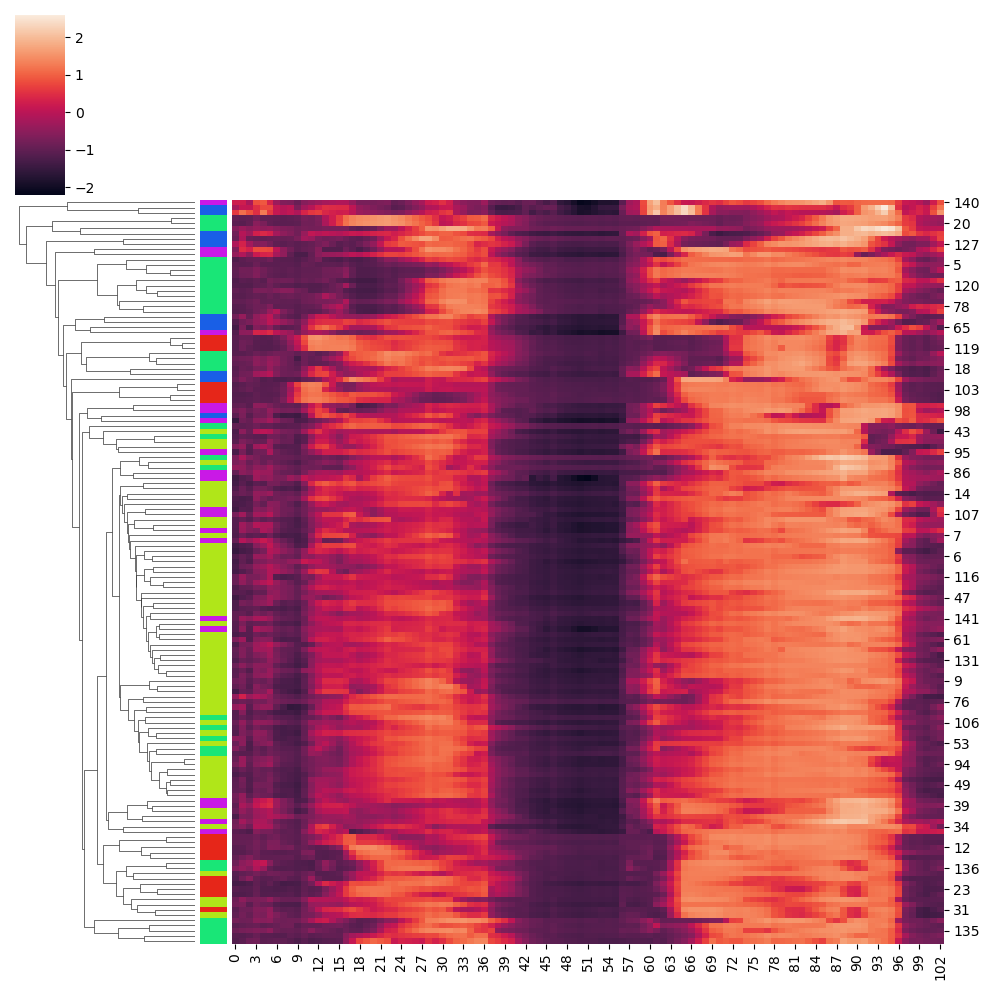

In [28]:
# try clustering without considering temporal info:

# clustermap will group based on euclidiean distance WITHOUT timeseries clustering

# row colors will indicate groupings based on time series clustering.

# plot the 'raw' NDVI values or the fit_transformed?
Xa = X.to_numpy(dtype='float')
Xa = X_train[:,:,0]

lut = dict(zip(set(y_pred), sns.hls_palette(len(set(y_pred)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(y_pred)[0].map(lut)

row_colors
sns.clustermap(Xa,
              row_cluster = True, 
              col_cluster = False,
              method = 'average',
              metric = 'euclidean',
              row_colors = row_colors.to_numpy())

## Notes for next time
- Probably best to resample the time series weekly, then interpolate over missing data. 
- This will the periodicity equal
- For exploratory purposes, might be better to consider years separately. 
- How many clusters best explains the data? try varying k. 
- does it make sense k-means plot to assess structure?
- which clustering method works best? compare sillouette scores
- What about instead of clustering NDVI, look at a function matching NDVI to climate data?
- Maybe try spectral clustering time series in order to consider multiple variables. 

### March 15
Trying other vegetation indices:
- NDYI: normalized difference yellowness index [potentially identifies canola flowering]
- FAPAR: 
- dNDVI: difference in NDVI at t compared to t - 1. [Maybe a better variable for ts clustering than NDVI alone?]
- 


In [29]:
def NDYI(green,blue):
    '''Normalized Difference Yellowness Index (NDYI) formula'
    Para E. S. https://custom-scripts.sentinel-hub.com/sentinel-2/ndyi/
    See link for idea on how to mask pixels with high NDYI'''
    
    return((green-blue)/(green+blue))

In [30]:
ds_ = ds
ds_

<xarray.Dataset>
Dimensions:      (time: 282, y: 529, x: 483)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-13T00:16:12.387000064 ... 2023...
  * y            (y) float64 -4.129e+06 -4.129e+06 ... -4.14e+06 -4.14e+06
  * x            (x) float64 1.432e+07 1.432e+07 ... 1.433e+07 1.433e+07
    spatial_ref  int32 6933
Data variables:
    nbart_red    (time, y, x) float32 ...
    nbart_green  (time, y, x) float32 ...
    nbart_blue   (time, y, x) float32 ...
    nbart_nir_1  (time, y, x) float32 ...
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [31]:
ds_['NDYI'] = NDYI(ds_['nbart_green'], ds_['nbart_blue'])
ds_

<xarray.Dataset>
Dimensions:      (time: 282, y: 529, x: 483)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-13T00:16:12.387000064 ... 2023...
  * y            (y) float64 -4.129e+06 -4.129e+06 ... -4.14e+06 -4.14e+06
  * x            (x) float64 1.432e+07 1.432e+07 ... 1.433e+07 1.433e+07
    spatial_ref  int32 6933
Data variables:
    nbart_red    (time, y, x) float32 ...
    nbart_green  (time, y, x) float32 ...
    nbart_blue   (time, y, x) float32 ...
    nbart_nir_1  (time, y, x) float32 ...
    NDYI         (time, y, x) float32 0.1686 0.1689 0.1666 ... 0.1024 0.1036
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

#### animation outputs 1
First, just a movie of the ds at every time step with polygons for a given cluster. 

In [32]:
path_animations = '/home/jovyan/Projects/PaddockTS/Results/'


/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Exporting animation to /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4_RGB_timelapse_K0.mp4


  0%|          | 0/282 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/pyth

Exporting animation to /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4_RGB_timelapse_K1.mp4


  0%|          | 0/282 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/pyth

Exporting animation to /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4_RGB_timelapse_K2.mp4


  0%|          | 0/282 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/pyth

Exporting animation to /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4_RGB_timelapse_K3.mp4


  0%|          | 0/282 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/pyth

Exporting animation to /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4_RGB_timelapse_K4.mp4


  0%|          | 0/282 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/pyth

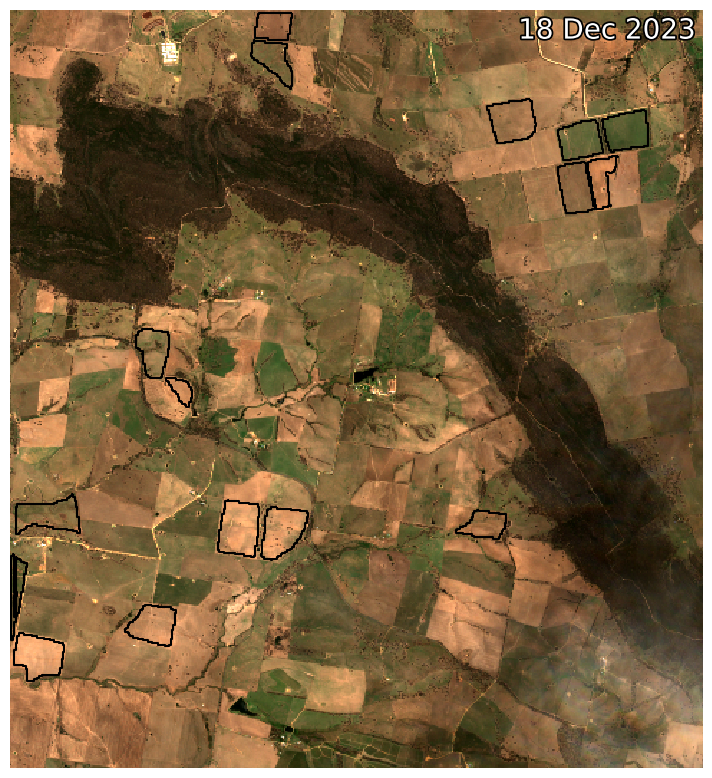

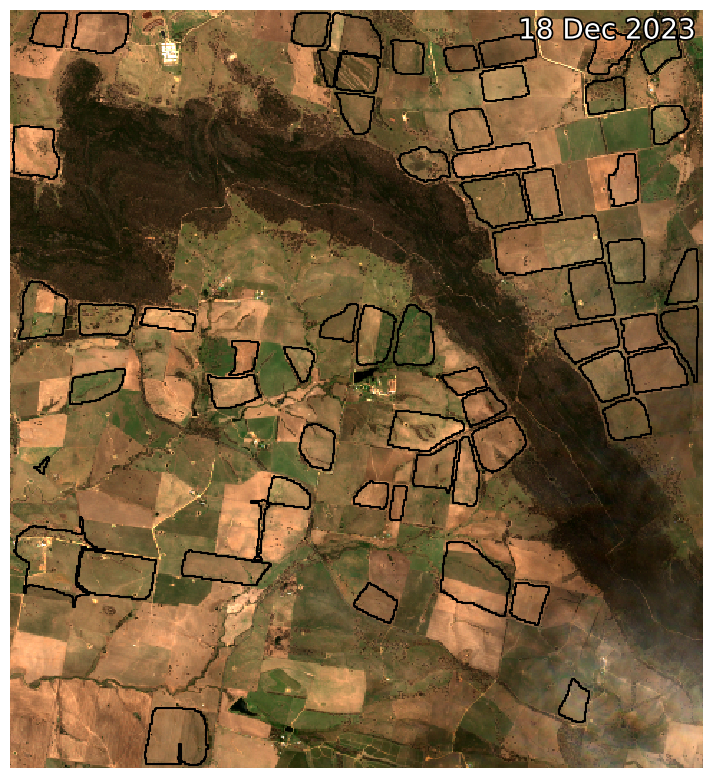

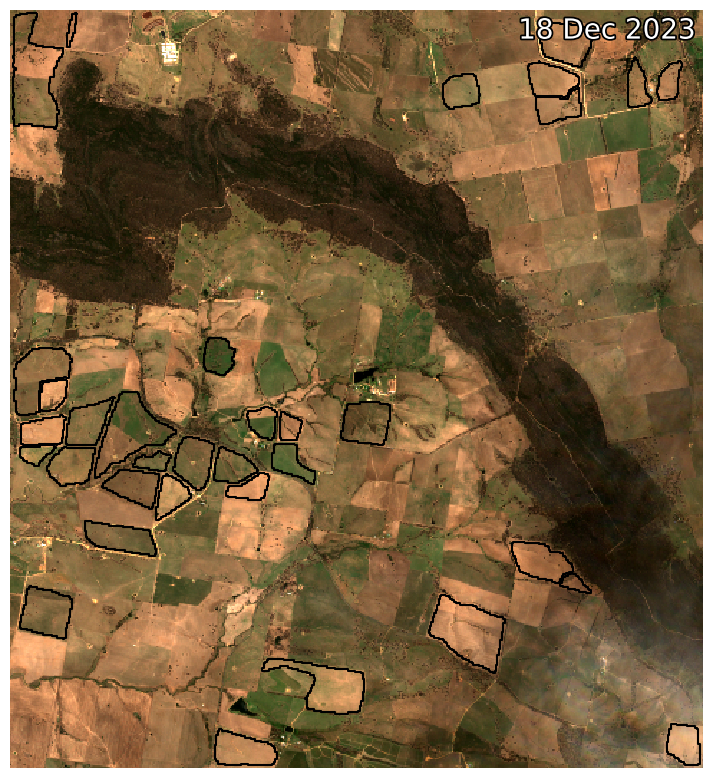

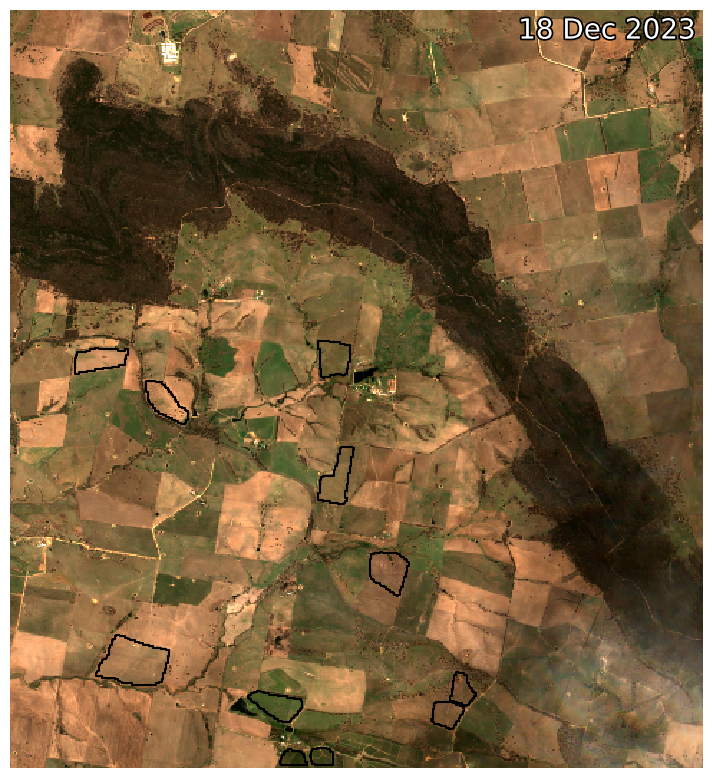

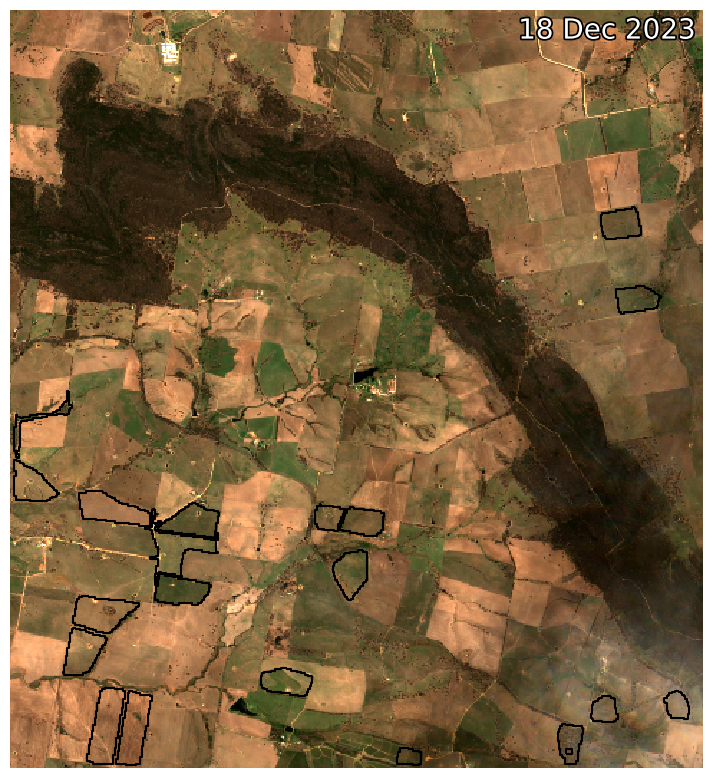

In [33]:
#### Makes a time lapse for every value of K, drawing only those polygons for cluster k. 


from dea_tools.plotting import display_map, rgb, xr_animation
import skimage

# specify number of frames
#num_frames = 20
num_frames = len(ds.time)

for K in range(N_CLUSTERS):
    gdf_ = pol[pol['y_pred'] == K] 

    #gdf_ = pol

    gdf_["color"] = '#FF000000' # can probably set a vector of colors here.. 

    # custom_funcs = [skimage.exposure.rescale_intensity,
    #                 skimage.exposure.equalize_adapthist]

    # Create animation with all the clusters
    xr_animation(ds, 
                 bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
                 output_path = path_animations+stub+'_RGB_timelapse_K'+str(K)+'.mp4', 
                 show_gdf = gdf_, 
                 gdf_kwargs={"edgecolor": "black"}, 
                 # image_proc_funcs=custom_funcs,
                 limit=num_frames)



In [59]:
# Plot animation
from IPython.display import Image
from IPython.core.display import Video

vid = path_animations+stub+'_NDYI_timelapse_test.mp4'

plt.close()
Video(vid, embed=True)


In [49]:
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS

colors.keys()

for i in range(len(list(colors))):
    print(colors[list(colors)[i]])

#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b
#e377c2
#7f7f7f
#bcbd22
#17becf


{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2', 7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}
Exporting animation to /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4_NDYI_timelapse_test.mp4


  0%|          | 0/20 (0.0 seconds remaining at ? frames/s)

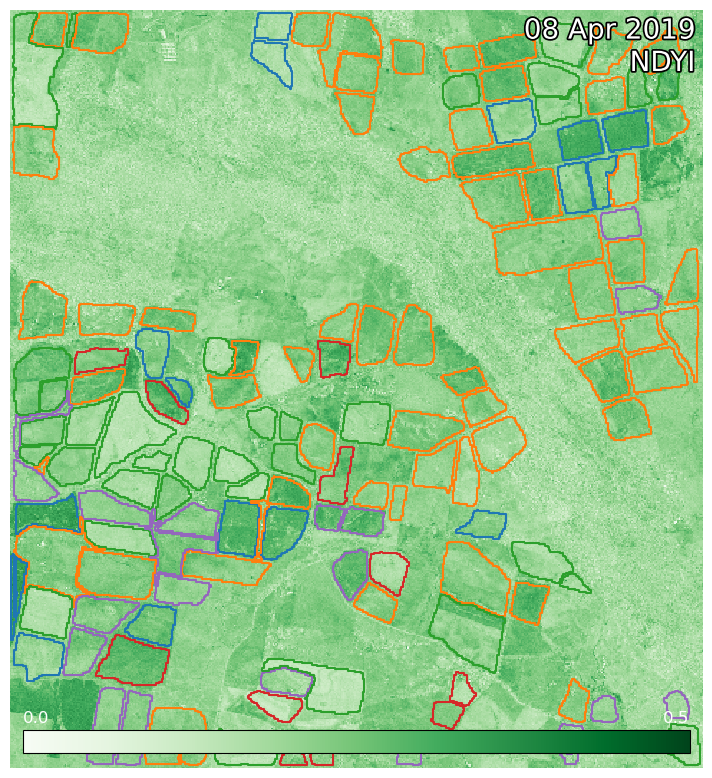

In [60]:

path_animations = '/home/jovyan/Projects/PaddockTS/Results/'

# specify number of frames
num_frames = 20
#num_frames = len(ds.time)

k = 1
gdf_ = pol[pol['y_pred'] == k] 

gdf_ = pol

# Set color for polygon fill (fully transparent)
gdf_["color"] = 'None' 

# Set colors for polygon edges (unique per cluster)
colors = {0:'#1f77b4',1:'#ff7f0e', 2:'#2ca02c', 3:'#d62728', 4:'#9467bd', 5:'#8c564b', 6:'#e377c2', 7:'#7f7f7f', 8:'#bcbd22', 9:'#17becf'}
colors
print(colors)

pol['color_edge'] = pol['y_pred'].map(colors)
pol['color_edge']
pol


# custom_funcs = [skimage.exposure.rescale_intensity,
#                 skimage.exposure.equalize_adapthist]

# Create animation with all the clusters
xr_animation(ds_, 
             bands=['NDYI'], 
             output_path = path_animations+stub+'_NDYI_timelapse_test.mp4', 
             show_gdf = gdf_, 
             #gdf_kwargs={"edgecolor": 'blue'},
             gdf_kwargs={"edgecolor": pol['color_edge']}, # Make edge color something different
             show_text="NDYI",
             imshow_kwargs={"cmap": "Greens", "vmin": 0.0, "vmax": 0.5},
             limit=num_frames)


In [58]:
pol

area  area_ha  log_area_ha  perim-area  \
0    176400.0    176.4     2.246499   10.204082   
1    207200.0    207.2     2.316390    9.459459   
2     31200.0     31.2     1.494155   39.743590   
3    192400.0    192.4     2.284205   10.395010   
4    373600.0    373.6     2.572407    7.173448   
..        ...      ...          ...         ...   
138  369600.0    369.6     2.567732    8.549784   
139   65600.0     65.6     1.816904   17.073171   
140   66000.0     66.0     1.819544   17.575758   
141  328000.0    328.0     2.515874    9.390244   
142   64000.0     64.0     1.806180   18.750000   

                                              geometry paddock y_pred  \
0    POLYGON ((14323920.000 -4129060.000, 14324380....       1      0   
1    POLYGON ((14324500.000 -4129060.000, 14324880....       2      1   
2    POLYGON ((14321340.000 -4129060.000, 14321380....       3      2   
3    POLYGON ((14320860.000 -4129060.000, 14321220....       4      1   
4    POLYGON ((14321420.000 -4129060.000, 14321960....       5      1   
..                                                 ...     ...    ...   
138  POLYGON ((14321760.000 -4138480.000, 14321900....     139      4   
139  POLYGON ((14324720.000 -4139320.000, 14324860....     140      3   
140  POLYGON ((14325880.000 -4139320.000, 14326000....     141      4   
141  POLYGON ((14322100.000 -4138520.000, 14322160....     142      4   
142  POLYGON ((14324320.000 -4139340.000, 14324380....     143      3   

         color color_edge  
0    #FF000000    #1f77b4  
1    #FF000000    #ff7f0e  
2    #FF000000    #2ca02c  
3    #FF000000    #ff7f0e  
4    #FF000000    #ff7f0e  
..         ...        ...  
138  #FF000000    #9467bd  
139  #FF000000    #d62728  
140  #FF000000    #9467bd  
141  #FF000000    #9467bd  
142  #FF000000    #d62728  

[143 rows x 9 columns]

### Time lapse plot with trace curves

array([[[-1.13419505],
        [-1.12036433],
        [-0.99680236],
        ...,
        [-0.81790601],
        [-0.84560733],
        [-0.87330865]],

       [[-1.29753532],
        [-1.23761655],
        [-1.15529942],
        ...,
        [-0.05639009],
        [-0.28764406],
        [-0.51889802]],

       [[-1.18764424],
        [-0.98441029],
        [-1.04204174],
        ...,
        [-0.48935768],
        [-0.4530016 ],
        [-0.41664564]],

       ...,

       [[ 0.21924482],
        [ 0.24714207],
        [-0.19484064],
        ...,
        [-0.34515051],
        [ 0.23608558],
        [ 0.81732143]],

       [[-1.01278288],
        [-0.361098  ],
        [-0.51771695],
        ...,
        [-0.82218901],
        [-0.74482885],
        [-0.66746869]],

       [[ 0.60867108],
        [ 1.13996839],
        [ 0.83816794],
        ...,
        [ 0.14459517],
        [ 0.84133414],
        [ 1.53807312]]])

In [61]:
# check the dimensions we're working with:
print(len(ds.time))
print(len(ds_weekly.time))
print(X_train.shape)

282
259
(143, 103, 1)


In [71]:
# If working with subset of time, get the relevant subset from ds_weekly

start = '2019-01-01'
end = '2021-01-01'

ds_weekly_ = ds_weekly.sel(time=slice(start, end))

ds_weekly_

<xarray.Dataset>
Dimensions:      (time: 103, y: 529, x: 483)
Coordinates:
  * y            (y) float64 -4.129e+06 -4.129e+06 ... -4.14e+06 -4.14e+06
  * x            (x) float64 1.432e+07 1.432e+07 ... 1.433e+07 1.433e+07
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2019-01-13 2019-01-20 ... 2020-12-27
Data variables:
    nbart_red    (time, y, x) float64 nan nan nan ... 1.129e+03 1.121e+03
    nbart_green  (time, y, x) float64 nan nan nan nan ... 808.8 808.9 807.7
    nbart_blue   (time, y, x) float64 nan nan nan nan ... 586.8 584.6 587.6
    nbart_nir_1  (time, y, x) float64 nan nan nan ... 1.954e+03 2.071e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [72]:
# clear the tmp directory and create anew
import os
import shutil
tmp_dir = "/home/jovyan/Projects/PaddockTS/tmp/"
shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir)

In [1]:
pol

NameError: name 'pol' is not defined

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2', 7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}
Exporting animation to /home/jovyan/Projects/PaddockTS/tmp/_rgb.mp4


  0%|          | 0/259 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/env/lib/pyth

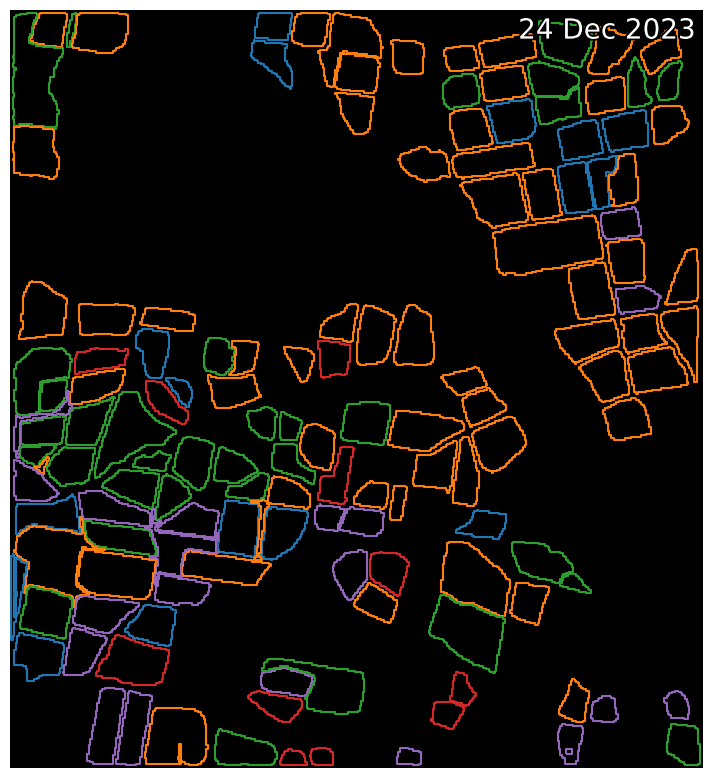

In [74]:
# Create animation 
animation_out = tmp_dir+'_rgb.mp4'

# Set color for polygon fill (fully transparent)
gdf_["color"] = 'None' 

# Set colors for polygon edges (unique per cluster)
colors = {0:'#1f77b4',1:'#ff7f0e', 2:'#2ca02c', 3:'#d62728', 4:'#9467bd', 5:'#8c564b', 6:'#e377c2', 7:'#7f7f7f', 8:'#bcbd22', 9:'#17becf'}
colors
print(colors)

pol['color_edge'] = pol['y_pred'].map(colors)

xr_animation(ds_weekly, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
             output_path = animation_out, 
             show_gdf = pol, 
             gdf_kwargs={"edgecolor": pol['color_edge']}
            )


In [75]:
# Function to extract frames 
def FrameCapture(video, outdir): 
  
    # Path to video file 
    vidObj = cv2.VideoCapture(video) 
  
    # Used as counter variable 
    count = 0
  
    # checks whether frames were extracted 
    success = 1
  
    while success: 
  
        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 
  
        # Saves the frames with frame-count 
        cv2.imwrite(outdir+"frame%d.jpg" % count, image) 
  
        count += 1

In [76]:
# Calling the function 
animation_out = tmp_dir+'_rgb.mp4'

FrameCapture(animation_out, tmp_dir) # seems to give an error on the last loop, even when it works.. Need to suppress this error message.

error: OpenCV(4.9.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [90]:
colors[list(colors)[0]]

'#1f77b4'

No. frames to plot: 103


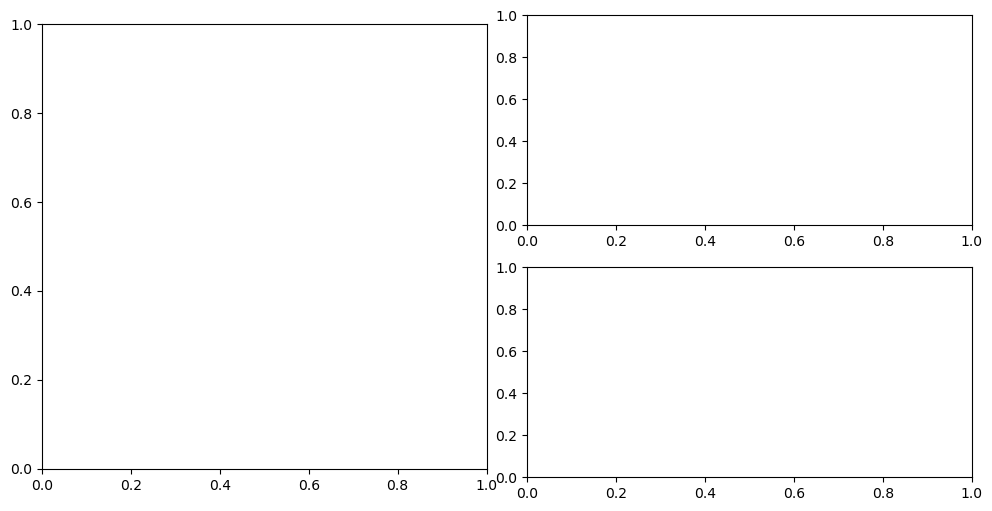

In [91]:
# K = <>


#cluster1_numframes = 282 
#n_frame = X_train.shape[1] # the total number of frames. Setting this way means it automatically updates if we change the input file.
n_frame = len(ds_weekly_.time)
#n_frame = 10
print("No. frames to plot:", n_frame)

fig = plt.figure(figsize = (12,6))
gs = GridSpec(2,4) # 2 = K


ax1 = fig.add_subplot(gs[:,:2])

# move below into loop through k (axk = 
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,2:])


for n in range(n_frame):
    # Plot image
    img = plt.imread(tmp_dir+"frame%d.jpg" % n)
    ax1.imshow(img)
    # Remove axes
    ax1.axis('off')
    
    # Plot line for current timestep
    ax2.plot([n,n],[-3,2])
    
    # Plot NDVI # replace with loop through range(K) (aka yi)
    yi=0
    color_k = colors[list(colors)[yi]] # get the color that goes with this cluster
    for xx in X_train[y_pred == yi]:
        ax2.plot(xx.ravel(), "k-", alpha=.2)
        ax2.plot(km.cluster_centers_[yi].ravel(), color_k)
        ax2.text(0.55, 0.85,'Cluster %d' % (yi), # Not sure why this text doesn't show...
             transform=plt.gca().transAxes)
        
    # Plot line for current timestep
    ax3.plot([n,n],[-3,2])
    
    yi=1
    color_k = colors[list(colors)[yi]] # get the color that goes with this cluster
    for xx in X_train[y_pred == yi]:
        ax3.plot(xx.ravel(), "k-", alpha=.2)
        ax3.plot(km.cluster_centers_[yi].ravel(), color_k)
        ax3.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
        
    ### Next time:
    ### We should loop through for yi in N_CLUSTERS, but we need to use N_CLUSTERS to set up the panels to begin with.
    
    # Save plot
    plt.savefig(tmp_dir+"multi_frame%d.jpg" % n)
    
    # Clear axes
    ax1.cla()
    ax2.cla()
    ax3.cla()

In [92]:
# start afain here

# Changed this block so we can pass python variables into the command line:
# Also, have to remove the outfile, otherwise get asked whether to overwrite...

infiles = tmp_dir+"multi_frame%d.jpg"
outfile = "/home/jovyan/Projects/PaddockTS/Results/"+stub+"multiplot_.mp4"

print(infiles, outfile)

! rm {outfile}
! ffmpeg -framerate 4 -i {infiles} -c:v libx264 -r 30 {outfile}

# EXAMPLE:
# # pass variable into shell command
# message = "hello from Python"
# !echo {message}


/home/jovyan/Projects/PaddockTS/tmp/multi_frame%d.jpg /home/jovyan/Projects/PaddockTS/Results/fm_ndwi_4multiplot_.mp4
ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-3)
  configuration: --prefix=/env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699837816504/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264

### Next time

Create a single jupyter notebook to go from inputs to outputs with this.

include an NDVI plot

show trace plots for all clusters. 


